# Prescriptor Experiments
#### This notebook is to replicate the process used in [Discovering Effective Policies for Land-Use Planning](https://doi.org/10.48550/arXiv.2311.12304)

In [29]:
import json
import os
from pathlib import Path

from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from data import constants
from data.eluc_data import ELUCData
from prescriptors.prescriptor import Prescriptor
from prescriptors.nsga2.torch_prescriptor import TorchPrescriptor
from prescriptors.esp.unileaf_prescriptor import UnileafPrescriptor
from prescriptors.heuristics.heuristics import EvenHeuristic, PerfectHeuristic
from prescriptors.nsga2.candidate import Candidate
from predictors.neural_network.neural_net_predictor import NeuralNetPredictor

In [30]:
dataset = ELUCData()

### Load Results

In [31]:
TOTAL_GENS = 100

esp_results_dir = Path("prescriptors/esp/trained_prescriptors/no-overlap/seeded")
torch_results_dir = Path("prescriptors/nsga2/trained_prescriptors/full")

In [32]:
def create_pareto_df(gen: int, results_dir: Path):
    last_gen_filename = results_dir / f"{gen}.csv"
    last_gen_df = pd.read_csv(last_gen_filename)
    pareto_df = last_gen_df[last_gen_df['NSGA-II_rank'] == 1]
    # Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
    pareto_df = pareto_df.sort_values(by='change', ascending=True)
    return pareto_df

In [33]:
esp_pareto_df = create_pareto_df(100, esp_results_dir)
torch_pareto_df = create_pareto_df(100, torch_results_dir)

### Figure Save Dir

In [34]:
figure_dir = Path("experiments/figures/no-overlap")
figure_dir.mkdir(parents=True, exist_ok=True)

## Generation Plotting

In [35]:
def get_pareto_df(dir, gen):
    """
    Gets the pareto df for a given generation.
    :param dir: The experiment results directory.
    :param gen: The generation to get the pareto df for.
    """
    gen_filename = os.path.join(dir, f"{gen}.csv")
    gen_df = pd.read_csv(gen_filename)
    gen_pareto_df = gen_df[gen_df['NSGA-II_rank'] == 1]
    # Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
    gen_pareto_df = gen_pareto_df.sort_values(by='change', ascending=True)
    gen_pareto_df["Name"] = f"Gen {gen}"
    return gen_pareto_df

def get_merged_df(dir, gens):
    """
    Gets the pareto df for multiple generations and merges them into one.
    :param dir: The experiment results directory.
    :param gens: List of generations to get the pareto df for.
    """
    dfs = []
    for gen in gens:
        dfs.append(get_pareto_df(dir, gen))
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

def get_overall_pareto_df(final_gen:int, results_dir: Path):
    pareto_list = []
    # First, go through each gen and add prescriptors that aren't already dominated.
    for gen in range(1, final_gen + 1):
        gen_path = results_dir / f"{gen}.csv"      
        gen_df = pd.read_csv(gen_path)
        gen_pareto_df = gen_df[gen_df['NSGA-II_rank'] == 1]
        for idx, row in gen_pareto_df.iterrows():
            pareto = True
            for p in pareto_list:
                # if (((p['ELUC'] < row['ELUC']) and (p['change'] <= row['change'])) or \
                #     ((p['ELUC'] <= row['ELUC']) and (p['change'] < row['change'])) or \
                #     ((p['ELUC'] == row['ELUC']) and (p['change'] == row['change']))):
                if p['ELUC'] <= row['ELUC'] and p['change'] <= row['change']:
                    pareto = False
                    break
            if pareto:
                pareto_list.append(row)

    # Go through the results and remove prescriptors that got dominated by later ones.
    filtered_pareto_list = []
    for i in range(len(pareto_list)):
        row = pareto_list[i]
        pareto = True
        for j in range(i+1, len(pareto_list)):
            p = pareto_list[j]
            # if (((p['ELUC'] < row['ELUC']) and (p['change'] <= row['change'])) or \
            #     ((p['ELUC'] <= row['ELUC']) and (p['change'] < row['change'])) or \
            #     ((p['ELUC'] == row['ELUC']) and (p['change'] == row['change']))):
            if p['ELUC'] <= row['ELUC'] and p['change'] <= row['change']:
                pareto = False
                break
        if pareto:
            filtered_pareto_list.append(row)

    return pd.DataFrame(filtered_pareto_list)


def plot_gens(dir, gens, save_path=None):
    """
    Plots the pareto front for multiple generations.
    :param dir: The experiment results directory.
    :param gens: List of generations to plot the pareto front for.
    """
    merged_df = get_merged_df(dir, gens)
    fig, ax = plt.subplots()
    cmap = plt.get_cmap("tab10")
    colors = [cmap(i) for i in [0, 1, 2, 5, 4]]
    curve_names = []
    for i, gen in enumerate(gens):
        curve_name = f"Gen {gen}"
        curve_names.append(curve_name)

        merged_df[merged_df["Name"] == curve_name].plot(x='change',
                       y='ELUC',
                       marker='o',
                       ylabel='ELUC',
                       ax=ax,
                       color=colors[i],
                       label="Gen " + str(gen))

    overall_pareto_df = get_overall_pareto_df(gens[-1], dir)
    overall_pareto_df = overall_pareto_df.sort_values(by="change")
    overall_pareto_df.plot(x='change', y='ELUC', c='r', marker='o', ax=ax, label="Final Pareto Front")
    #plt.xlim(0, 0.4)
    plt.grid() 
    # handles, labels = plt.gca().get_legend_handles_labels()
    # order = [0, 1, 2, 4, 3]
    # plt.legend([handles[idx] for idx in order], [curve_names[idx] for idx in order], loc="upper right")
    plt.legend(prop={'size': 9})
    #plt.title("Pareto Fronts Across Generations")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

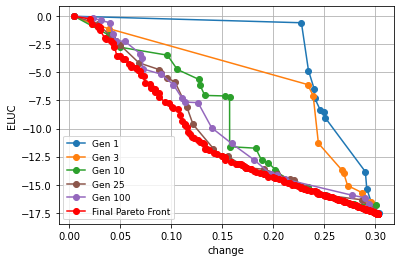

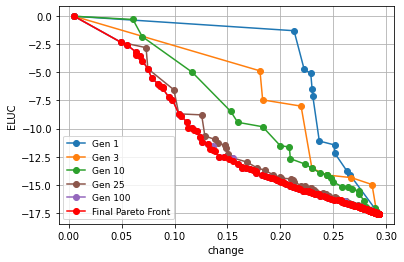

In [36]:
gens_to_plot = [1, 3, 10, 25, 100]
plot_gens(esp_results_dir, gens_to_plot, save_path=None)
plot_gens(torch_results_dir, gens_to_plot, save_path=None)

In [37]:
def get_gen_df(gen: int, results_dir: Path):
    gen_filename = results_dir / f"{gen}.csv"
    gen_df = pd.read_csv(gen_filename)
    # Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
    gen_df = gen_df.sort_values(by='change', ascending=True)
    gen_df["Name"] = f"Gen {gen}"
    return gen_df

def get_all_gens_df(gens: list, results_dir: Path):
    dfs = []
    for gen in gens:
        dfs.append(get_gen_df(gen, results_dir))
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

In [38]:
def plot_all_gens(gens: list, results_dir: Path, save_path=None):
    all_gens_df = get_all_gens_df(gens, results_dir)
    fig, ax = plt.subplots()

    all_gens_df.plot.scatter(x='change',
                             y='ELUC',
                             ax=ax,
                             label="All prescriptors evaluated")
    # Plot last gen's pareto front in red
    
    #get_pareto_df(dir, gens[-1]).plot.scatter(x='change', y='ELUC', c='red', ax=ax, label="Gen 100 Pareto Front")
    overall_pareto = get_overall_pareto_df(gens[-1], results_dir)
    overall_pareto.plot.scatter(x='change', y='ELUC', c='red', ax=ax, label="Final Pareto Front")
    plt.grid()
    #plt.title("All Generations All Prescriptor Performance")
    plt.legend(loc="upper left")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300) 
    plt.show()

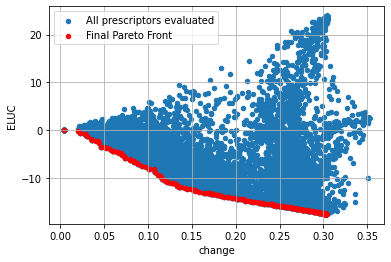

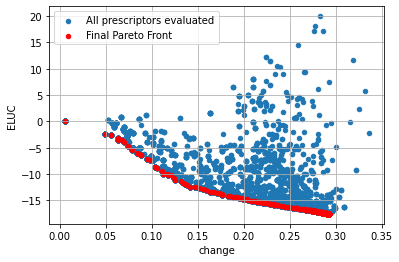

In [39]:
all_gens = [a + 1 for a in range(100)]
plot_all_gens(all_gens, esp_results_dir, save_path=None)
plot_all_gens(all_gens, torch_results_dir, save_path=None)

In [41]:
esp_all_pareto_df = get_overall_pareto_df(100, esp_results_dir)
torch_all_pareto_df = get_overall_pareto_df(100, torch_results_dir)
# TODO:
torch_all_pareto_df["id"] = torch_all_pareto_df["cand_id"]

## Comparison with Heuristic

In [43]:
nnp = NeuralNetPredictor.from_pretrained("predictors/neural_network/trained_models/no_overlap_nn")
presc_config = None
with open("prescriptors/esp/unileaf_configs/config-loctime-crop-nosoft.json") as f:
    presc_config = json.load(f)
unileaf_prescriptor = UnileafPrescriptor(presc_config,
                                   dataset.train_df.iloc[:1],
                                   dataset.encoder,
                                   [nnp])

candidate_params = {"in_size": len(constants.CAO_MAPPING["context"]), "hidden_size": 16, "out_size": len(constants.RECO_COLS)}
torch_prescriptor = TorchPrescriptor(
                               None, 
                               dataset.encoder, 
                               nnp, 
                               4096, 
                               candidate_params)

In [44]:
even_heuristic = EvenHeuristic("secdf", nnp)

linreg = LinearRegression()
linreg.fit(dataset.train_df[constants.DIFF_LAND_USE_COLS], dataset.train_df["ELUC"])
coefs = linreg.coef_
coef_dict = dict(zip(constants.LAND_USE_COLS, coefs))
reco_coefs = []
for col in constants.RECO_COLS:
    reco_coefs.append(coef_dict[col])

perfect_heuristic = PerfectHeuristic(reco_coefs, nnp)

In [45]:
test_df = dataset.test_df.sample(frac=0.01, random_state=100)
encoded_test_df = dataset.encoder.encode_as_df(test_df)

context_df = test_df[constants.CAO_MAPPING["context"]]
encoded_context_df = encoded_test_df[constants.CAO_MAPPING["context"]]

### Trained Prescriptors

In [46]:
def evaluate_prescriptor(context_df: pd.DataFrame, prescriptor: Prescriptor, **kwargs):
    context_actions_df = prescriptor.prescribe_land_use(context_df, **kwargs)
    eluc_df, change_df = prescriptor.predict_metrics(context_actions_df)
    return eluc_df["ELUC"].mean(), change_df["change"].mean()

In [47]:
assert len(esp_all_pareto_df["id"].unique()) == len(esp_all_pareto_df)
assert len(torch_all_pareto_df["id"].unique()) == len(torch_all_pareto_df)

esp_ids = esp_all_pareto_df["id"].tolist()
esp_elucs = []
esp_changes = []
for id in tqdm(esp_ids):
    eluc, change = evaluate_prescriptor(context_df, unileaf_prescriptor, cand_id=id, results_dir=esp_results_dir)
    esp_elucs.append(eluc)
    esp_changes.append(change)

torch_ids = torch_all_pareto_df["id"].tolist()
torch_elucs = []
torch_changes = []
for id in tqdm(torch_ids):
    eluc, change = evaluate_prescriptor(context_df, torch_prescriptor, cand_id=id, results_dir=torch_results_dir)
    torch_elucs.append(eluc)
    torch_changes.append(change)

  0%|          | 0/213 [00:00<?, ?it/s]

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

757/757 [==============================] - 3s 4ms/step


  0%|          | 1/213 [00:04<15:23,  4.36s/it]

757/757 [==============================] - 3s 4ms/step


  1%|          | 2/213 [00:07<13:34,  3.86s/it]

757/757 [==============================] - 3s 3ms/step


  1%|▏         | 3/213 [00:11<12:25,  3.55s/it]

757/757 [==============================] - 3s 3ms/step


  2%|▏         | 4/213 [00:14<12:17,  3.53s/it]

757/757 [==============================] - 3s 3ms/step


  2%|▏         | 5/213 [00:17<11:49,  3.41s/it]

757/757 [==============================] - 3s 3ms/step


  3%|▎         | 6/213 [00:20<11:29,  3.33s/it]

757/757 [==============================] - 3s 3ms/step


  3%|▎         | 7/213 [00:24<11:15,  3.28s/it]

757/757 [==============================] - 3s 3ms/step


  4%|▍         | 8/213 [00:27<11:27,  3.35s/it]

757/757 [==============================] - 3s 3ms/step


  4%|▍         | 9/213 [00:30<11:13,  3.30s/it]

757/757 [==============================] - 3s 3ms/step


  5%|▍         | 10/213 [00:33<11:02,  3.26s/it]

757/757 [==============================] - 3s 3ms/step


  5%|▌         | 11/213 [00:37<10:53,  3.23s/it]

757/757 [==============================] - 3s 3ms/step


  6%|▌         | 12/213 [00:40<11:09,  3.33s/it]

757/757 [==============================] - 3s 3ms/step


  6%|▌         | 13/213 [00:43<10:59,  3.30s/it]

757/757 [==============================] - 3s 3ms/step


  7%|▋         | 14/213 [00:47<10:47,  3.25s/it]

757/757 [==============================] - 3s 3ms/step


  7%|▋         | 15/213 [00:50<10:40,  3.23s/it]

757/757 [==============================] - 3s 3ms/step


  8%|▊         | 16/213 [00:53<10:50,  3.30s/it]

757/757 [==============================] - 3s 3ms/step


  8%|▊         | 17/213 [00:56<10:42,  3.28s/it]

757/757 [==============================] - 3s 3ms/step


  8%|▊         | 18/213 [01:00<10:33,  3.25s/it]

757/757 [==============================] - 3s 3ms/step


  9%|▉         | 19/213 [01:03<10:25,  3.23s/it]

757/757 [==============================] - 3s 3ms/step


  9%|▉         | 20/213 [01:06<10:41,  3.32s/it]

757/757 [==============================] - 3s 3ms/step


 10%|▉         | 21/213 [01:10<10:32,  3.29s/it]

757/757 [==============================] - 3s 3ms/step


 10%|█         | 22/213 [01:13<10:23,  3.27s/it]

757/757 [==============================] - 3s 3ms/step


 11%|█         | 23/213 [01:16<10:14,  3.23s/it]

757/757 [==============================] - 3s 3ms/step


 11%|█▏        | 24/213 [01:19<10:28,  3.33s/it]

757/757 [==============================] - 3s 3ms/step


 12%|█▏        | 25/213 [01:23<10:20,  3.30s/it]

757/757 [==============================] - 3s 3ms/step


 12%|█▏        | 26/213 [01:26<10:12,  3.28s/it]

757/757 [==============================] - 3s 3ms/step


 13%|█▎        | 27/213 [01:29<10:04,  3.25s/it]

757/757 [==============================] - 3s 3ms/step


 13%|█▎        | 28/213 [01:33<10:15,  3.33s/it]

757/757 [==============================] - 3s 3ms/step


 14%|█▎        | 29/213 [01:36<10:08,  3.30s/it]

757/757 [==============================] - 3s 3ms/step


 14%|█▍        | 30/213 [01:39<09:58,  3.27s/it]

757/757 [==============================] - 3s 3ms/step


 15%|█▍        | 31/213 [01:42<09:51,  3.25s/it]

757/757 [==============================] - 3s 3ms/step


 15%|█▌        | 32/213 [01:46<09:59,  3.31s/it]

757/757 [==============================] - 3s 3ms/step


 15%|█▌        | 33/213 [01:49<09:52,  3.29s/it]

757/757 [==============================] - 3s 3ms/step


 16%|█▌        | 34/213 [01:52<09:43,  3.26s/it]

757/757 [==============================] - 3s 3ms/step


 16%|█▋        | 35/213 [01:55<09:36,  3.24s/it]

757/757 [==============================] - 3s 3ms/step


 17%|█▋        | 36/213 [01:59<09:48,  3.32s/it]

757/757 [==============================] - 3s 3ms/step


 17%|█▋        | 37/213 [02:02<09:40,  3.30s/it]

757/757 [==============================] - 3s 3ms/step


 18%|█▊        | 38/213 [02:05<09:32,  3.27s/it]

757/757 [==============================] - 3s 3ms/step


 18%|█▊        | 39/213 [02:08<09:24,  3.25s/it]

757/757 [==============================] - 3s 3ms/step


 19%|█▉        | 40/213 [02:12<09:36,  3.33s/it]

757/757 [==============================] - 3s 3ms/step


 19%|█▉        | 41/213 [02:15<09:30,  3.32s/it]

757/757 [==============================] - 3s 3ms/step


 20%|█▉        | 42/213 [02:19<09:21,  3.28s/it]

757/757 [==============================] - 3s 3ms/step


 20%|██        | 43/213 [02:22<09:14,  3.26s/it]

757/757 [==============================] - 3s 3ms/step


 21%|██        | 44/213 [02:25<09:22,  3.33s/it]

757/757 [==============================] - 3s 4ms/step


 21%|██        | 45/213 [02:29<09:26,  3.37s/it]

757/757 [==============================] - 3s 4ms/step


 22%|██▏       | 46/213 [02:32<09:37,  3.46s/it]

757/757 [==============================] - 3s 4ms/step


 22%|██▏       | 47/213 [02:36<09:36,  3.47s/it]

757/757 [==============================] - 3s 3ms/step


 23%|██▎       | 48/213 [02:40<09:47,  3.56s/it]

576/757 [=====================>........] - ETA: 0s

In [ ]:
pcts = [i/len(esp_ids) for i in range(1, len(esp_ids) + 1)]
even_elucs = []
even_changes = []
perfect_elucs = []
perfect_changes = []
for pct in tqdm(pcts):
    even_eluc, even_change = evaluate_prescriptor(context_df, even_heuristic, pct=pct)
    even_elucs.append(even_eluc)
    even_changes.append(even_change)
    perfect_eluc, perfect_change = evaluate_prescriptor(context_df, perfect_heuristic, pct=pct)
    perfect_elucs.append(perfect_eluc)
    perfect_changes.append(perfect_change)

100%|██████████| 213/213 [01:46<00:00,  2.00it/s]


In [ ]:
def order_pareto_points(changes, elucs):
    zipped = zip(changes, elucs)
    ordered = sorted(zipped, key=lambda x: x[0])
    return zip(*ordered)

In [ ]:
esp_changes_sorted, esp_elucs_sorted = order_pareto_points(esp_changes, esp_elucs)
torch_changes_sorted, torch_elucs_sorted = order_pareto_points(torch_changes, torch_elucs)

In [ ]:
def plot_result_pareto(all_results, save_path=None):
    for result_name, results in all_results.items():
        plt.scatter(results[0], results[1], color=results[2], label=result_name)

    plt.legend()
    plt.xlabel("change")
    plt.ylabel("ELUC")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

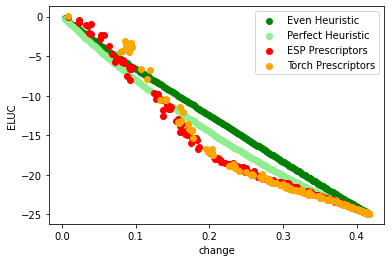

In [ ]:
all_results = {
    "Even Heuristic": (even_changes, even_elucs, "green"),
    "Perfect Heuristic": (perfect_changes, perfect_elucs, "lightgreen"),
    "ESP Prescriptors": (esp_changes, esp_elucs, "red"),
    "Torch Prescriptors": (torch_changes, torch_elucs, "orange")
}
plot_result_pareto(all_results)

In [ ]:
def filter_dominating(changes, elucs):
    """
    Gets indices of points that are not dominated by any other point.
    """
    non_dominated_idxs = []
    for i in range(len(changes)):
        dominated = False
        for j in range(len(changes)):
            if i != j and changes[i] >= changes[j] and elucs[i] >= elucs[j]:
                dominated = True
                break
        if not dominated:
            non_dominated_idxs.append(i)
    
    return [changes[i] for i in non_dominated_idxs], [elucs[i] for i in non_dominated_idxs]


def two_dim_decreasing_neg_hypervolume(x, y, right=1):
    """
    Computes the hypervolume of a 2d pareto.
    We use the sklearn AUC function to find the area between our curve and y = 0,
    then we add the area of the rectangle to the right of the pareto.
    This assumes the y coordinate of the reference point is 0 (which it is in our ELUC case).
    We only consider points under y = 0, adding point 0,0 to the pareto if it is not there.
    :param x: List of x coordinates between [0, 1]
    :param y: List of y coordinates
    :param right: the rightmost edge to compute the rectangle to. Defaults to 1.
    """

    assert len(x) == len(y)
    assert all([0 <= x_i <= 1 for x_i in x])
    assert right >= max(x)

    # Filter out positive y values
    neg_idxs = [i for i in range(len(y)) if y[i] < 0]
    x = [x[i] for i in neg_idxs]
    y = [y[i] for i in neg_idxs]

    # Sort the pareto by x
    sorted_x = sorted(x)
    sorted_y = [y[x.index(sorted_x[i])] for i in range(len(x))]

    # Add point 0,0 if it is not there
    if sorted_x[0] != 0:
        sorted_x = [0] + sorted_x
        sorted_y = [0] + sorted_y

    # Add bottom right point if it is not there
    if sorted_x[-1] != right:
        sorted_x.append(right)
        sorted_y.append(sorted_y[-1])

    # Take the rectangle that is to the top right of each point.
    area = 0
    for i in range(len(sorted_x) - 2, -1, -1):
        area += (sorted_x[i] - sorted_x[i + 1]) * sorted_y[i]

    return area

In [ ]:
# Filter out points that are dominated by others
esp_changes_filtered, esp_elucs_filtered = filter_dominating(esp_changes_sorted, esp_elucs_sorted)
torch_changes_filtered, torch_elucs_filtered = filter_dominating(torch_changes_sorted, torch_elucs_sorted)

print(f"Even hypervolume: {two_dim_decreasing_neg_hypervolume(even_changes, even_elucs)}")
print(f"Perfect hypervolume: {two_dim_decreasing_neg_hypervolume(perfect_changes, perfect_elucs)}")
print(f"ESP hypervolume: {two_dim_decreasing_neg_hypervolume(esp_changes_filtered, esp_elucs_filtered)}")
print(f"Torch hypervolume: {two_dim_decreasing_neg_hypervolume(torch_changes_filtered, torch_elucs_filtered)}")

Even hypervolume: 19.883448199417447
Perfect hypervolume: 20.450602282335318
ESP hypervolume: 20.704040842702252
Torch hypervolume: 20.37706786923874


## Examine Results

In [ ]:
def get_idx_close(change, changes):
    diff = [abs(c - change) for c in changes]
    idx = diff.index(min(diff))
    return idx

def plot_selected_points(selected_points, save_path=None):
    for point_name, point in selected_points.items():
        plt.scatter([point[0]], [point[1]], color=point[2], label=point_name)

    plt.legend()
    plt.xlabel("change")
    plt.ylabel("ELUC")
    plt.xlim([0, 0.4])
    plt.ylim([-25, 0])
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

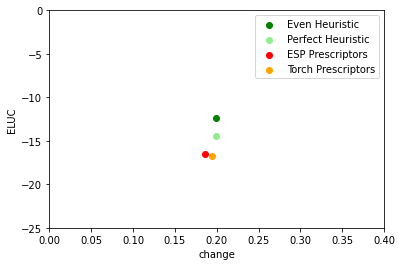

In [ ]:
pct = 0.2
even_idx = get_idx_close(pct, even_changes)
perfect_idx = get_idx_close(pct, perfect_changes)
esp_idx = get_idx_close(pct, esp_changes_sorted) - 1
torch_idx = get_idx_close(pct, torch_changes_sorted) - 1

selected_points = {
    "Even Heuristic": (even_changes[even_idx], even_elucs[even_idx], "green"),
    "Perfect Heuristic": (perfect_changes[perfect_idx], perfect_elucs[perfect_idx], "lightgreen"),
    "ESP Prescriptors": (esp_changes_sorted[esp_idx], esp_elucs_sorted[esp_idx], "red"),
    "Torch Prescriptors": (torch_changes_sorted[torch_idx], torch_elucs_sorted[torch_idx], "orange")
}

plot_selected_points(selected_points)

In [ ]:
def trained_prescribe_and_predict(context_df: pd.DataFrame, prescriptor: Prescriptor, **kwargs):
    context_actions_df = prescriptor.prescribe_land_use(context_df, **kwargs)
    eluc_df, change_df = prescriptor.predict_metrics(context_actions_df)
    context_actions_df["ELUC"] = eluc_df["ELUC"]
    context_actions_df["change"] = change_df["change"]
    return context_actions_df

In [ ]:
esp_unsorted_idx = esp_changes.index(esp_changes_sorted[esp_idx])
esp_id = esp_all_pareto_df["id"].iloc[esp_unsorted_idx]
esp_result = trained_prescribe_and_predict(context_df, unileaf_prescriptor, cand_id=esp_id, results_dir=esp_results_dir)

torch_unsorted_idx = torch_changes.index(torch_changes_sorted[torch_idx])
torch_id = torch_all_pareto_df["id"].iloc[torch_unsorted_idx]
torch_result = trained_prescribe_and_predict(context_df, torch_prescriptor, cand_id=torch_id, results_dir=torch_results_dir)

even_result = trained_prescribe_and_predict(context_df, even_heuristic, pct=pcts[even_idx])
perfect_result = trained_prescribe_and_predict(context_df, perfect_heuristic, pct=pcts[perfect_idx])

757/757 [==============================] - 4s 4ms/step


In [ ]:
def plot_expanded(result_dict: dict, save_path=None):
    # Evolved first so that it is on the bottom
    for sample_name, result in result_dict.items():
        plt.scatter(result[0], result[1], color=result[2], label=sample_name)
    
    # Rearrange legend (from stackoverflow)
    # handles, labels = plt.gca().get_legend_handles_labels()
    # order = [1, 2, 0]
    # plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    plt.legend()
    plt.xlabel("change")
    plt.ylabel("ELUC")
    #plt.title("Expanded view of ~20% change prescriptors (subsampled)")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

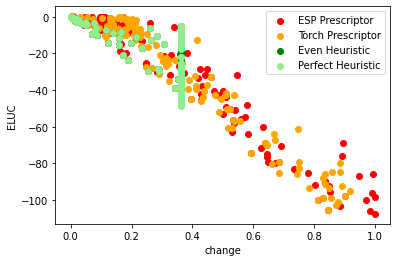

In [ ]:
esp_sample =  esp_result.sample(frac=0.01, random_state=42)
torch_sample = torch_result.loc[esp_sample.index]
even_sample = even_result.loc[esp_sample.index]
perfect_sample = perfect_result.loc[esp_sample.index]

expanded_results = {
    "ESP Prescriptor": (esp_sample["change"], esp_sample["ELUC"], "red"),
    "Torch Prescriptor": (torch_sample["change"], torch_sample["ELUC"], "orange"),
    "Even Heuristic": (even_sample["change"], even_sample["ELUC"], "green"),
    "Perfect Heuristic": (perfect_sample["change"], perfect_sample["ELUC"], "lightgreen"),
}

plot_expanded(expanded_results)

In [ ]:
def create_diff_df(trained_result, perfect_result):
    eluc_diff = trained_result["ELUC"] - perfect_result["ELUC"]
    change_diff = trained_result["change"] - perfect_result["change"]
    diff_df = pd.concat([eluc_diff, change_diff], axis=1)

    return diff_df

In [ ]:
esp_diff = create_diff_df(esp_sample, perfect_sample)
torch_diff = create_diff_df(torch_sample, perfect_sample)

In [ ]:
def plot_diffs(diff_df, save_path=None):
    
    dom = diff_df[(diff_df["change"] < 0) & (diff_df["ELUC"] < 0)]
    other_dom = diff_df[(diff_df["change"] > 0) & (diff_df["ELUC"] > 0)]

    plt.scatter(diff_df["change"], diff_df["ELUC"], label="No domination")
    plt.scatter(other_dom["change"], other_dom["ELUC"], color="lightgreen", label="Perfect Heuristic dominates")
    plt.scatter(dom["change"], dom["ELUC"], color="red", label="Evolved Prescriptor dominates")
    plt.axhline(0, color="black", linestyle="--")
    plt.axvline(0, color="black", linestyle="--")
    plt.xlabel("Change Difference")
    plt.ylabel("ELUC Difference")
    #plt.title("Change Diff vs. ELUC Diff Between Trained and Perfect (subsampled)")
    plt.legend()
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

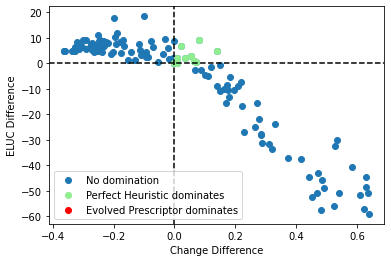

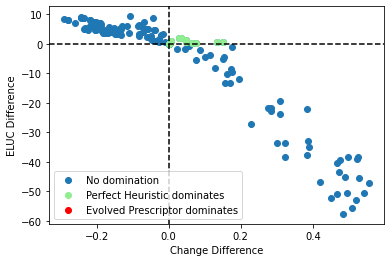

In [ ]:
plot_diffs(esp_diff)
plot_diffs(torch_diff)

In [ ]:
def display_dominating(diff_df):
    low_change_idx = diff_df["change"][(diff_df["change"] < 0)].index
    low_change_eluc_diff = diff_df["ELUC"][low_change_idx]
    low_change_neg_eluc_diff = low_change_eluc_diff[low_change_eluc_diff < 0]
    print(f"Number less change better ELUC: {len(low_change_neg_eluc_diff)}")
    if len(low_change_neg_eluc_diff) > 0:
        min_idx = low_change_neg_eluc_diff.sort_values().index[0]
        print(f"Max difference in ELUC with less change: {diff_df['ELUC'][min_idx]}")

    signif = low_change_neg_eluc_diff[abs(low_change_neg_eluc_diff) > 0.05]
    print(f"Number of points where trained prescriptor prescribes less change than perfect heuristic AND produces better ELUC by more than predictor model MAE: {len(signif)}")
    print(f"Average difference in change for these points: {diff_df['change'].loc[signif.index].mean()}")
    print(f"Average difference in ELUC for these points: {signif.mean()}")
    print()

In [ ]:
display_dominating(esp_diff)
display_dominating(torch_diff)

Number less change better ELUC: 0
Number of points where trained prescriptor prescribes less change than perfect heuristic AND produces better ELUC by more than predictor model MAE: 0
Average difference in change for these points: nan
Average difference in ELUC for these points: nan

Number less change better ELUC: 0
Number of points where trained prescriptor prescribes less change than perfect heuristic AND produces better ELUC by more than predictor model MAE: 0
Average difference in change for these points: nan
Average difference in ELUC for these points: nan



In [ ]:
def plot_avg_presc(result_dict, save_path=None):
    xticks = np.arange(len(constants.DIFF_RECO_COLS))
    i = 0
    width = 1 / (len(result_dict) + 1)
    for result_name, result in result_dict.items():
        plt.bar(xticks + i * width, result[0][constants.DIFF_RECO_COLS].mean(), width=width, label=result_name, color=result[1])
        i += 1
    
    plt.xticks(xticks + (len(result_dict)-1)/2 * width, constants.DIFF_RECO_COLS, rotation=90)
    plt.legend()
    plt.grid()
    #plt.title("Average land use change for each prescriptor")
    fig = plt.gcf()
    fig.set_tight_layout(True)
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

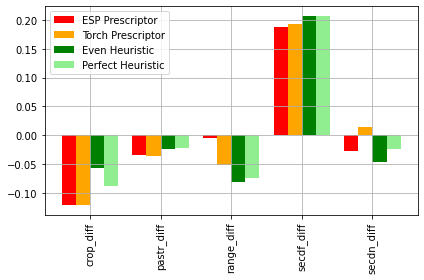

In [ ]:
plot_avg_presc({
    "ESP Prescriptor": (esp_sample, "red"),
    "Torch Prescriptor": (torch_sample, "orange"),
    "Even Heuristic": (even_sample, "green"),
    "Perfect Heuristic": (perfect_sample, "lightgreen"),
})

#### See what features cause more change

In [ ]:
def plot_corrs(result_df, save_path=None):
    rs = []
    for col in constants.LAND_USE_COLS + constants.NONLAND_FEATURES:
        feat = result_df[col]
        if col == "lat" or col == "lon":
            feat = abs(feat)
        rs.append(feat.corr(result_df["change"]))
    print(rs)

    labels = constants.LAND_USE_COLS + constants.NONLAND_FEATURES
    labels[labels.index("lat")] = "abs(lat)"
    labels[labels.index("lon")] = "abs(lon)"
    plt.bar(labels, rs)
    plt.xticks(rotation=90)
    plt.xlabel("Context Feature")
    plt.ylabel("r value")
    plt.title("Linear Correlation Between Context and Amount of Prescribed Change")
    plt.grid(axis="y")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

[0.9230349380998744, 0.43807104207699554, -0.29004901879260875, -0.2351340289893659, -0.05092533293805986, -0.09623288169068946, 0.13216382229535967, 0.15509841768596153, 0.32893283987412425, -0.2783848147588405, -0.21376403628922513, 0.014942717949453916]


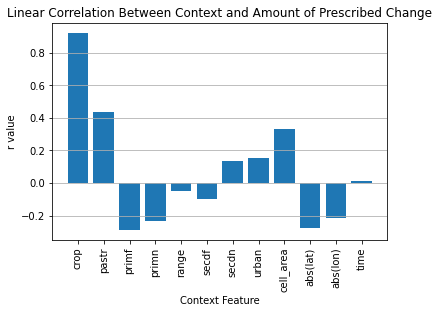

[0.9059005993480254, 0.5011587606004066, -0.31973205797930904, -0.3059206272223369, 0.07049172159692892, -0.10795210782289759, 0.1576329101792274, 0.14580177100167327, 0.3985471113103744, -0.34303557055794415, -0.2238433660617915, 0.014087250251697304]


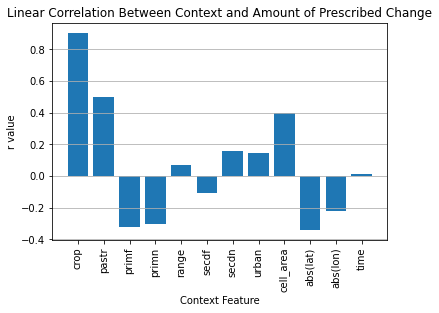

In [ ]:
plot_corrs(esp_result)
plot_corrs(torch_result)

In [ ]:
def plot_context_change(trained_sample, feature, save):
    plt.scatter(trained_sample[feature], trained_sample["change"])
    plt.title(f"Context {feature} vs. Amount of Prescribed Change")
    plt.ylabel("Change")
    plt.xlabel(feature)
    if feature in constants.LAND_USE_COLS:
        plt.plot([0, 1], [0, 1], color="black", linestyle="--", label="y=x")
        plt.plot([0, 1], [1, 0], color="red", linestyle="--", label="y=1-x")
        plt.legend()
    if save:
        plt.savefig(f"figures/{feature}change.png", format="png", dpi=300)
    plt.show()

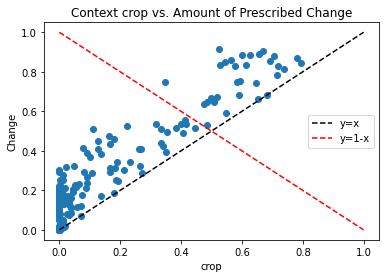

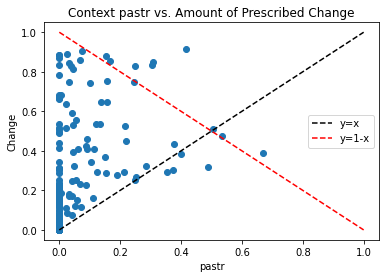

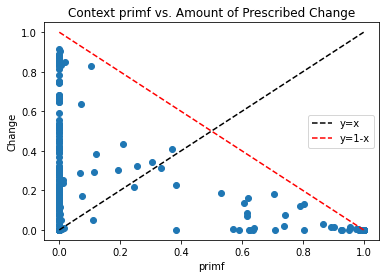

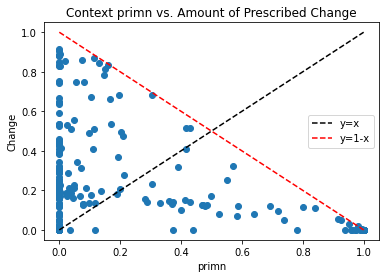

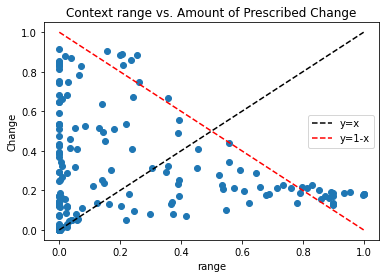

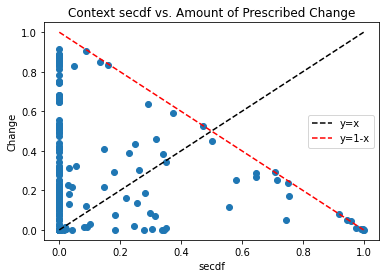

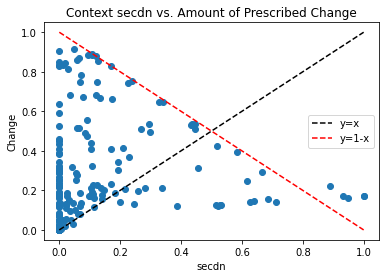

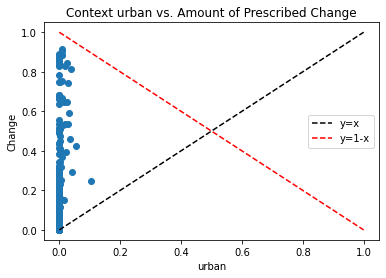

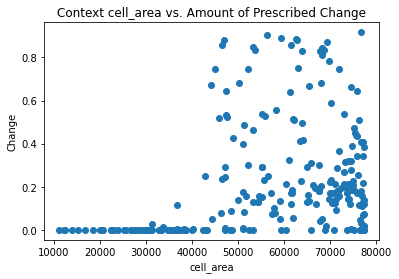

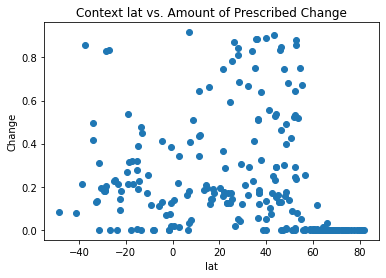

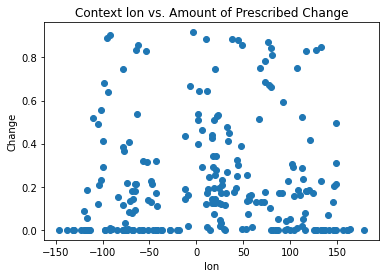

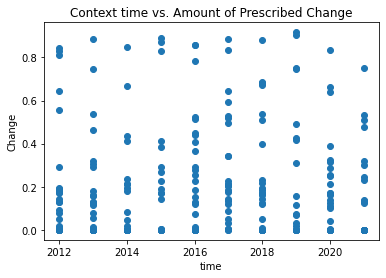

In [ ]:
for feature in constants.LAND_USE_COLS + constants.NONLAND_FEATURES:
    plot_context_change(torch_sample, feature, False)

## Compare to Global Warming

In [ ]:
pcts = [0.01, 0.05, 0.1, 0.2, 0.5, 1]
total_emissions = []
total_changes = []
for pct in tqdm(pcts):
    result_df = perfect_heuristic.prescribe_land_use(dataset.test_df.loc[2021][constants.CAO_MAPPING["context"]], pct=pct)
    eluc_df, change_df = perfect_heuristic.predict_metrics(result_df)
    result_df["ELUC"] = eluc_df["ELUC"]
    result_df["change"] = change_df["change"]
    result_df["total_emissions"] = result_df["ELUC"] * result_df["cell_area"]
    result_df["total_change"] = result_df["change"] * result_df["cell_area"]
    total_emissions.append(result_df["total_emissions"].sum())
    total_changes.append(result_df["total_change"].sum() / result_df["cell_area"].sum())

100%|██████████| 6/6 [00:10<00:00,  1.78s/it]


In [ ]:
# Weight of CO2 vs. C
conversion = 3.664
# Remaining Carbon budget
rcb = 250
rcb2 = 1200
# Yearly net emissions
yearly = 20

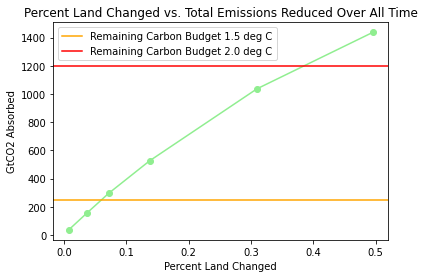

In [ ]:
fig = plt.figure(facecolor="white")
plt.plot(total_changes, [-1 * t * conversion / 1e9 for t in total_emissions], marker="o", color="lightgreen")
plt.axhline(y=rcb, color='orange', label="Remaining Carbon Budget 1.5 deg C")
plt.axhline(y=rcb2, color='red', label="Remaining Carbon Budget 2.0 deg C")
plt.legend()
plt.title("Percent Land Changed vs. Total Emissions Reduced Over All Time")
plt.ylabel("GtCO2 Absorbed")
plt.xlabel("Percent Land Changed")
plt.show()

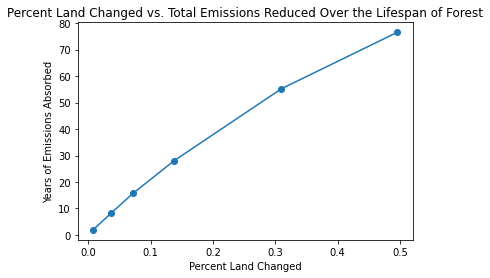

In [ ]:
fig = plt.figure(facecolor="white")
plt.plot(total_changes, [t / (-18.78e9 / conversion) for t in total_emissions], marker="o")
plt.title("Percent Land Changed vs. Total Emissions Reduced Over the Lifespan of Forest")
plt.xlabel("Percent Land Changed")
plt.ylabel("Years of Emissions Absorbed")
plt.show()